## POI ID
#### Udacity Data Analyst Nanodegree
#### Final Project

The goal of this project is to identify the persons of interest related to collapse of Enron in 2002. These POIs perpetrated widespread corporate accounting fraud to hide billions of dollars in debt from failed deals and projects.

### 1. Define packages and import Enron data

In [2]:
#!/usr/bin/python
# Import packages
import sys
import pickle
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
  


C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Create a list of initial features

In [3]:
# all feature list
features_list = data_dict['ALLEN PHILLIP K'].keys()

# Remove email address & Add poi at beginning of list
features_list.remove('email_address')
features_list.remove('poi')
features_list.insert(0,'poi')
print features_list

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


#### Split dataset into labels and features

In [31]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
print 'Dim Features: ',len(features), len(features[0])
print 'Dim labels: ',len(labels)


# Convert list to numpy array
features = numpy.asarray(features)
labels = numpy.asarray(labels)
print 'Numpy Array features and labels: ',features.shape, labels.shape

Dim Features:  145 19
Dim labels:  145
Numpy Array features and labels:  (145L, 19L) (145L,)


### 2. Remove Outliers

Create plots for some attributes to find outliers.

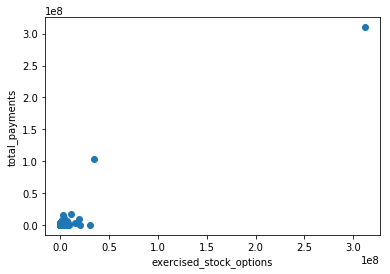

In [6]:
# look for large outliers from the data
plt.scatter(features[:,4], features[:,3])
plt.xlabel("exercised_stock_options")
plt.ylabel("total_payments")
plt.show()

There seems to be large outlier in the data. In the next step, we simply remove that outlier.

In [32]:
# Extract index of large value for exercised stock options and delete it
outlier = numpy.where(features[:,4] == features[:,4].max())[0][0]
print 'Outlier index: ',outlier

### Task 2: Remove outliers
print 'Dim of features and lables before removing outlier: ',features.shape,labels.shape
features = numpy.delete(features,outlier, axis=0)
labels = numpy.delete(labels,outlier, axis=0)
print 'Dim of features and lables after removing outlier: ',features.shape,labels.shape

Outlier index:  129
Dim of features and lables before removing outlier:  (145L, 19L) (145L,)
Dim of features and lables after removing outlier:  (144L, 19L) (144L,)


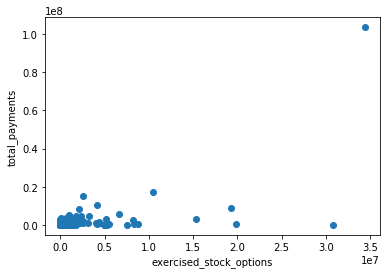

In [33]:
# Check if large outliers from the data is removed
plt.scatter(features[:,4], features[:,3])
plt.xlabel("exercised_stock_options")
plt.ylabel("total_payments")
plt.show()

### 3. Identify and keep important features

Next, run a decision tree on the entire dataset to identify important features. Only those features with importance score > .05 is kept

In [34]:
# Look for important variables using decision tree 
# Note that this step is done to recognise important varaible that we want
# check outliers for
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(features, labels)

features_list1=[]
for i,j in zip(features_list[1:],numpy.ndenumerate(dtc.feature_importances_)):
    print i,':    ', j[1]    
    # Keep all features with importance > .05
    if j[1]>.05:
        features_list1.append(i)
    
# Append poi in the beginning
features_list1.insert(0,'poi')
# Append to and from messages at the end
features_list1.append('from_messages')
features_list1.append('to_messages')
print ''
print 'Kept features ---------->',features_list1
    
    

salary :     0.0
to_messages :     0.0
deferral_payments :     0.0
total_payments :     0.112874779541
exercised_stock_options :     0.231746031746
bonus :     0.109451528031
restricted_stock :     0.120480432567
shared_receipt_with_poi :     0.0577200577201
restricted_stock_deferred :     0.0
total_stock_value :     0.0
expenses :     0.117875473623
loan_advances :     0.0
from_messages :     0.0
other :     0.138852968951
from_this_person_to_poi :     0.0554431722656
director_fees :     0.0
deferred_income :     0.0
long_term_incentive :     0.0
from_poi_to_this_person :     0.0555555555556

Kept features ----------> ['poi', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'expenses', 'other', 'from_this_person_to_poi', 'from_poi_to_this_person', 'from_messages', 'to_messages']


#### Recreate the dataset using important features selected

In [36]:
### ReExtract features and labels from dataset using the most important feature list
data = featureFormat(my_dataset, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Convert list to numpy array
features = numpy.asarray(features)
labels = numpy.asarray(labels)
labels = numpy.reshape(labels,(len(labels),1))

### Remove outliers
# Extract index of large value for exercised stock options and delete it
outlier = numpy.where(features[:,1] == features[:,1].max())[0][0]

# Remove outliers
features = numpy.delete(features,outlier, axis=0)
labels = numpy.delete(labels,outlier, axis=0)
print 'Dim of features and labels with important features only: ',features.shape, labels.shape


Dim of features and labels with important features only:  (144L, 11L) (144L, 1L)


In [44]:
features[numpy.isna(features)]

AttributeError: 'module' object has no attribute 'isna'

### 4. Create new features

Based on the importance of features, and the domain knowledge, I decided to create following new features:

* **ratio_bonus_to_ex_stock:** ratio of bonus to exercised_stock_options
* **from_this_person_to_poi_pctof_from:** from_this_person_to_poi as % of from_messages
* **from_poi_to_this_person_pctof_to:** from_poi_to_this_person as % of to_messages
* **ratio_restrc_stock_to_total_pmnt:** ratio of restricted_stock to total_payments 
* **ratio_ex_stock_to_total_pmnt:** ratio of exercised_stock_options to total_payments


In [47]:

### Task 3: Create new feature(s)

def new_features(ds):
    
    # ratio of bonus to exercised stock options
    f1 = 0
    f1 = ds[:,2]/ds[:,1]
    f1[numpy.isnan(f1)] = 0 # Remove nan
    f1[numpy.isinf(f1)] = 0 # Remove infinity
    f1 = numpy.reshape(f1,(len(f1),1)) # Reshape Array
    
    # from_this_person_to_poi as % of from_messages
    f2 = 0
    f2 = ds[:,7]/ds[:,9]
    f2[numpy.isnan(f2)] = 0 # Remove nan
    f2[numpy.isinf(f2)] = 0 # Remove infinity
    f2 = numpy.reshape(f2,(len(f2),1)) # Reshape Array
    
    # from_poi_to_this_person as % of to_messages
    f3 = 0
    f3 = ds[:,8]/ds[:,10]
    f3[numpy.isnan(f3)] = 0 # Remove nan
    f3[numpy.isinf(f3)] = 0 # Remove infinity
    f3 = numpy.reshape(f3,(len(f3),1)) # Reshape Array
    
    # ratio of restricted_stock to total_payments
    f4 = 0
    f4 = ds[:,3]/ds[:,0]
    f4[numpy.isnan(f4)] = 0 # Remove nan
    f4[numpy.isinf(f4)] = 0 # Remove infinity
    f4 = numpy.reshape(f4,(len(f4),1)) # Reshape Array
    
    # ratio of exercised_stock_options to total_payments
    f5 = 0
    f5 = ds[:,1]/ds[:,0]
    f5[numpy.isnan(f5)] = 0 # Remove nan
    f5[numpy.isinf(f5)] = 0 # Remove infinity
    f5 = numpy.reshape(f5,(len(f5),1)) # Reshape Array
    
    # Concatenate new features
    return numpy.concatenate((ds,f1,f2,f3,f4,f5),axis = 1)
    
# Add new features to train and test sets
features = new_features(features)

# update feature list
features_list_updt = features_list1
features_list_updt.extend(['ratio_bonus_to_ex_stock', 'from_this_person_to_poi_pctof_from',
                           'from_poi_to_this_person_pctof_to', 'ratio_restrc_stock_to_total_pmnt', 
                           'ratio_ex_stock_to_total_pmnt'])

print 'List of label and all features incl. new ones: '
for i in features_list_updt:
    print '          ',i
    
print 'Number of label and all features incl. new ones: ',len(features_list_updt)

 
print "--------------------------------"    
    

List of label and all features incl. new ones: 
           poi
           total_payments
           exercised_stock_options
           bonus
           restricted_stock
           shared_receipt_with_poi
           expenses
           other
           from_this_person_to_poi
           from_poi_to_this_person
           from_messages
           to_messages
           ratio_bonus_to_ex_stock
           from_this_person_to_poi_pctof_from
           from_poi_to_this_person_pctof_to
           ratio_restrc_stock_to_total_pmnt
           ratio_ex_stock_to_total_pmnt
           ratio_bonus_to_ex_stock
           from_this_person_to_poi_pctof_from
           from_poi_to_this_person_pctof_to
           ratio_restrc_stock_to_total_pmnt
           ratio_ex_stock_to_total_pmnt
           ratio_bonus_to_ex_stock
           from_this_person_to_poi_pctof_from
           from_poi_to_this_person_pctof_to
           ratio_restrc_stock_to_total_pmnt
           ratio_ex_stock_to_total_pmnt
           rat

C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: divide by zero encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in divide
C:\Users\pneupane\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: 

#### Split the dataset with new features into train and test

In [48]:
# Split into test/train datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.30, random_state=42)
print 'Dim of train features and labels: ',features_train.shape, features_test.shape
print 'Dim of test features and labels: ',labels_train.shape, labels_test.shape

Dim of train features and labels:  (100L, 31L) (44L, 31L)
Dim of test features and labels:  (100L, 1L) (44L, 1L)


#### Create a dictionary with overall data to be used as input for final testing

In [16]:
# Combine test/train, features/labels into one dataset 
# This will later be passed to the test_classifier function

#all_features = numpy.concatenate((features_train,features_test),axis = 0)
#all_labels =  numpy.concatenate((labels_train,labels_test),axis = 0)

all_ds = numpy.concatenate((labels,features), axis=1)
print all_ds.shape

# Save the data in dictionary (cannot make this work!!!)
#d = {i: {j: v for j, v in enumerate(row) if v}
#    for i, row in enumerate(all_ds)}

# Save the data in dictionary
f= features_list_updt
d = {}
for i, row in enumerate(all_ds):
    temp = {}
    for j, v in enumerate(row):
            temp[f[j]] = v # Use feature list as key
    d[i] = temp
    
d

(144L, 17L)


{0: {'bonus': 4175000.0,
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_poi_to_this_person_pctof_to': 0.016195727084769126,
  'from_this_person_to_poi': 65.0,
  'from_this_person_to_poi_pctof_from': 0.029612756264236904,
  'other': 152.0,
  'poi': 0.0,
  'ratio_bonus_to_ex_stock': 2.4139352579672875,
  'ratio_ex_stock_to_total_pmnt': 0.38567585443183344,
  'ratio_restrc_stock_to_total_pmnt': 0.028103161998750348,
  'restricted_stock': 126027.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0},
 1: {'bonus': 0.0,
  'exercised_stock_options': 257817.0,
  'expenses': 3486.0,
  'from_messages': 0.0,
  'from_poi_to_this_person': 0.0,
  'from_poi_to_this_person_pctof_to': 0.0,
  'from_this_person_to_poi': 0.0,
  'from_this_person_to_poi_pctof_from': 0.0,
  'other': 0.0,
  'poi': 0.0,
  'ratio_bonus_to_ex_stock': 0.0,
  'ratio_ex_stock_to_total_pmnt': 1.41295912663


### 5. Try variety of transformations and classifiers to predict the POIs

Here, we use different combinations of transformations (SelectKBest, StandardScaler, PCA, etc.) and different types of classifiers (GaussianNB, SVM, RandomForestClassifier, etc,.) to select the best approach.

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score,recall_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest

def test_run(pipe):
    clf = pipe.fit(features_train, labels_train)
    cv = ShuffleSplit(n_splits=50, test_size=0.3)
    score =  cross_val_score(clf, features_train, labels_train, cv=cv, scoring='f1')
    
    
    print '--------------------------------------------------------------'
    print pipe
    #print 'cv f1 scores: ',score
    print 'cv mean score: ',score.mean()

    pred = clf.predict(features_test)

    #########################################################
    # Print accuracy #
    print '--------------------------------------------------------------'
    print 'Test accuracy: %.2f' % (float(sum(1 for ii in range(0, len(labels_test)) if labels_test[ii]==pred[ii]))/float(len(labels_test)))

    # Print f1
    print 'Test f1: %.2f' % (metrics.f1_score(labels_test,pred))
    # Print precision
    print 'Test precision: %.2f' % (precision_score(labels_test,pred))
    # Print recall
    print 'Test recall: %.2f' % (recall_score(labels_test,pred))
    print '--------------------------------------------------------------'
    
    return clf

print '--------------------------------------------------------------'    
print 'GaussianNB'
pipe = make_pipeline( GaussianNB())
test_run(pipe)

print '--------------------------------------------------------------'
print 'StandardScaler/GaussianNB'
pipe = make_pipeline(preprocessing.StandardScaler(), GaussianNB())
test_run(pipe)

print '--------------------------------------------------------------'
print 'SVM'
pipe = make_pipeline( svm.SVC(C=10))
test_run(pipe)

print '--------------------------------------------------------------'
print 'StandardScaler/SVM'
pipe = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=10))
test_run(pipe)

print '--------------------------------------------------------------'
print 'RandomForestClassifier'
pipe = make_pipeline( RandomForestClassifier())
test_run(pipe)

print '--------------------------------------------------------------'
print 'StandardScaler/RandomForestClassifier'
pipe = make_pipeline( preprocessing.StandardScaler(), RandomForestClassifier())
test_run(pipe)

print '--------------------------------------------------------------'
print 'SelectKBest/RandomForestClassifier'
pipe = make_pipeline( SelectKBest(k=6), RandomForestClassifier())
test_run(pipe)


--------------------------------------------------------------
GaussianNB
--------------------------------------------------------------
Pipeline(memory=None, steps=[('gaussiannb', GaussianNB(priors=None))])
cv mean score:  0.26612290977
--------------------------------------------------------------
Test accuracy: 0.89
Test f1: 0.44
Test precision: 0.50
Test recall: 0.40
--------------------------------------------------------------
--------------------------------------------------------------
StandardScaler/GaussianNB
--------------------------------------------------------------
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gaussiannb', GaussianNB(priors=None))])
cv mean score:  0.281907177618
--------------------------------------------------------------
Test accuracy: 0.77
Test f1: 0.29
Test precision: 0.22
Test recall: 0.40
--------------------------------------------------------------
---------------------------

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=6, score_func=<function f_classif at 0x0000000009FF9208>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decre...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Here, GaussianNB has the largest f1 value, and SelectKBest/RandomForestClassifier has second largest value. I decide to go with SelectKBest/RandomForestClassifier because it was easier to tune parameters for this combination.

### 6. Tune parameters for selected classifiers

After attempting to tune several different combinations, I settled with SelectKBest/RandomForestClassifier.

In [58]:

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
'''
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
'''




# Pipeline Steps

if True:
    steps = [
             ('SKBfeature',SelectKBest()),
             ('RFclf',RandomForestClassifier(class_weight ='balanced_subsample') )]
    
if False:
    steps = [
             ('PCAfeature',PCA()),
             ('RFclf',RandomForestClassifier(class_weight ='balanced_subsample') )]

if False:
    steps = [
             ('RFclf',RandomForestClassifier( ) ) ]


pipeline = Pipeline(steps)



# Input Parameters

if True:
    parameters = dict(SKBfeature__k = [2,4,6],
                      RFclf__n_estimators = [20,30,40],
                      RFclf__max_depth = [3,5,7]                  
                     )

    
if False:
    parameters = dict(PCAfeature__n_components = [2,4],
                      RFclf__n_estimators = [10,20,50],
                      RFclf__max_depth = [3,5]                  
                     )

if False:
    parameters = dict(
                      RFclf__n_estimators = [10,20,30],
                      RFclf__max_depth = [3]                  
                     )


# Cross Validator
cross_validator = StratifiedShuffleSplit(labels_train,100, random_state = 42)

# Call Gridsearch
cv1 = GridSearchCV(pipeline,  param_grid=parameters, cv = cross_validator, scoring='f1', verbose=1)

print cv1

#cv1.fit(all_features, all_labels) # Label_train does not accept 2d array, so it had to be 'flattened'

cv1.fit(features_train, labels_train)

pred = cv1.predict(features_test)


print zip(pred, labels_test)
#########################################################
# Print accuracy #
print 'Accuracy: %.2f' % (float(sum(1 for ii in range(0, len(labels_test)) if labels_test[ii]==pred[ii]))/float(len(labels_test)))

# Print f1
print 'f1: %.2f' % (metrics.f1_score(labels_test,pred))

# Print precision
print 'Precision: %.2f' % (precision_score(labels_test,pred))

# Print recall
print 'Recall: %.2f' % (recall_score(labels_test,pred))



GridSearchCV(cv=StratifiedShuffleSplit(labels=[[ 0.]
 [ 0.]
 ...,
 [ 0.]
 [ 0.]], n_iter=100, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('SKBfeature', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009FF9208>)), ('RFclf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrea...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'RFclf__n_estimators': [20, 30, 40], 'RFclf__max_depth': [3, 5, 7], 'SKBfeature__k': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=1)
Fitting 100 folds for each of 27 candidates, totalling 2700 fits
[(0.0, array([ 0.])), (0.0, array([ 0.])), (0.0, array([ 0.])), (0.0, array([ 0.])), (0.0, array([ 0.])

[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed:  3.0min finished



### 7. Save datasets, classifier and features list into .pkl files

Extract the best combinaiton of parameters.

In [59]:
print 'estimator --------->'
print cv1.best_estimator_
fs = cv1.best_estimator_.named_steps['SKBfeature']
#selected_features = fs.transform(numpy.reshape(features_list_updt,(1,len(features_list_updt))))


feature_names = numpy.array(features_list_updt[1:])

print
print 'Selected K Features by Estimator and their scores ---------> '
print zip(feature_names[fs.get_support()], fs.scores_[fs.get_support()])


estimator --------->
Pipeline(memory=None,
     steps=[('SKBfeature', SelectKBest(k=4, score_func=<function f_classif at 0x0000000009FF9208>)), ('RFclf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0...imators=40, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Selected Features by Estimator and their scores ---------> 
[('bonus', 30.652282305660439), ('from_this_person_to_poi_pctof_from', 13.791413236761116), ('from_this_person_to_poi_pctof_from', 13.791413236761116), ('from_this_person_to_poi_pctof_from', 13.791413236761116)]


#### Dump classifier, dataset and features list into .pkl file

In [61]:

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

from tester import test_classifier
dump_classifier_and_data(cv1.best_estimator_, d, features_list_updt)
